In [116]:
import warnings
from io import BytesIO
from pathlib import Path
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile
import numpy as np
import pandas as pd
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels
from sklearn.metrics import brier_score_loss, roc_auc_score
from socceraction.spadl.wyscout import convert_to_spadl
from socceraction.vaep.formula import value
from tqdm.notebook import tqdm
from xgboost import XGBClassifier

In [3]:
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

In [4]:
#download the data
data_files = {
    'events': 'https://ndownloader.figshare.com/files/14464685',  # ZIP file containing one JSON file for each competition
    'matches': 'https://ndownloader.figshare.com/files/14464622',  # ZIP file containing one JSON file for each competition
    'players': 'https://ndownloader.figshare.com/files/15073721',  # JSON file
    'teams': 'https://ndownloader.figshare.com/files/15073697'  # JSON file
}

In [5]:
#for url in tqdm(data_files.values()):
    #url_s3 = urlopen(url).geturl()
    #path = Path(urlparse(url_s3).path)
    #file_name = path.name
    #file_local, _ = urlretrieve(url_s3, file_name)
    #if is_zipfile(file_local):
        #with ZipFile(file_local) as zip_file:
            #zip_file.extractall()

In [6]:
#preprocess the data 
def read_json_file(filename):
    with open(filename, 'rb') as json_file:
        return BytesIO(json_file.read()).getvalue().decode('unicode_escape')

In [7]:
json_teams = read_json_file('teams.json')
df_teams = pd.read_json(json_teams)

In [8]:
df_teams.to_hdf('wyscout.h5', key='teams', mode='w')

In [9]:
json_players = read_json_file('players.json')
df_players = pd.read_json(json_players)

In [10]:
df_players.to_hdf('wyscout.h5', key='players', mode='a')

In [11]:
#types of competition
competitions = [
    'Spain',
    'European Championship',
    'World Cup',
    'France',
    'Italy',
    'Germany'
]

In [12]:
dfs_matches = []
for competition in competitions:
    competition_name = competition.replace(' ', '_')
    file_matches = f'matches_{competition_name}.json'
    json_matches = read_json_file(file_matches)
    df_matches = pd.read_json(json_matches)
    dfs_matches.append(df_matches)
df_matches = pd.concat(dfs_matches)

In [13]:
df_matches.to_hdf('wyscout.h5', key='matches', mode='a')

In [14]:
for competition in competitions:
    print(competition)
    competition_name = competition.replace(' ', '_')
    file_events = f'events_{competition_name}.json'
    json_events = read_json_file(file_events)
    df_events = pd.read_json(json_events)
    df_events_matches = df_events.groupby('matchId', as_index=False)
    for match_id, df_events_match in df_events_matches:
        df_events_match.to_hdf('wyscout.h5', key=f'events/match_{match_id}', mode='a')

Spain
European Championship
World Cup
France
Italy
Germany


In [15]:
#convert to the SPADL system 
convert_to_spadl('wyscout.h5', 'spadl.h5')

...Inserting actiontypes
...Inserting bodyparts
...Inserting results
...Converting games
...Converting players
...Converting teams
...Generating player_games


100%|████████████████████████████████████████████████████████████████████████████| 1561/1561 [03:29<00:00,  7.45game/s]


...Converting events to actions


100%|████████████████████████████████████████████████████████████████████████████| 1561/1561 [21:51<00:00,  1.19game/s]


In [16]:
df_games = pd.read_hdf('spadl.h5', key='games')
df_actiontypes = pd.read_hdf('spadl.h5', key='actiontypes')
df_bodyparts = pd.read_hdf('spadl.h5', key='bodyparts')
df_results = pd.read_hdf('spadl.h5', key='results')

In [118]:
#include the plus/minus as a feature
#plus/minus of shots allowed 
def plusminus(df_actions):
    #teams = df_actions['team_id'].unique()
    pm_0 = []
    shots = []
    team1_shot_frame = []
    team2_shot_frame = []
    shot_diff = 0

    for j in range(0,len(df_actions)):
       
        if df_actions.iloc[j]["type_name"] == "shot":
            shots.append(1)
            
            #team1
            if df_actions.iloc[j]["team_id"] == df_actions['team_id'].unique()[0]:
                team1_shot_frame.append(j)
                shot_diff = len(team1_shot_frame) - len(team2_shot_frame)

                pm_0.append(shot_diff)
                
            elif df_actions.iloc[j]["team_id"] == df_actions['team_id'].unique()[1]:
                team2_shot_frame.append(j)
                shot_diff =len(team2_shot_frame) - len(team1_shot_frame)
                pm_0.append(shot_diff)
                
        else:
            if df_actions.iloc[j]["team_id"] == df_actions['team_id'].unique()[0]:
                shot_diff = len(team1_shot_frame) - len(team2_shot_frame)
                pm_0.append(shot_diff)

            elif df_actions.iloc[j]["team_id"] == df_actions['team_id'].unique()[1]:
                shot_diff =len(team2_shot_frame) - len(team1_shot_frame)
                pm_0.append(shot_diff)
        
    pm_0 = pd.DataFrame(pm_0, columns=['pm_ao'])
    y = pd.concat([pm_0, df_actions['team_id']], axis=1)
    y.columns = ['pm_ao', 'team_id']

    # adding previous pm results
    for i in range(1, nb_prev_actions):
        for col in ['pm_ao']:
            shifted = y[col].shift(-i)
            shifted[-i:] = y[col][len(y) - 1]
            y[f'pm_a{i}'] = shifted           

    
    return(y)
    

In [119]:
nb_prev_actions = 5

In [120]:
#create the features for our model
#use some of the already created code for some of the features 
#follow code from the repository
#use the same features that they had and add some of our own
functions_features = [
    #Get the one-hot-encoded type of each action
    features.actiontype_onehot,
    #Get the one-hot-encoded bodypart of each action
    features.bodypart_onehot,
    #Get the one-hot-encode result of each action
    features.result_onehot,
    #Get the number of goals scored by each team after the action
    features.goalscore,
    #Get the location where each action started
    features.startlocation,
    #Get the location where each action ended
    features.endlocation,
    #Get the distance covered by each action
    features.movement,
    #Get the distance covered between the last and previous actions
    features.space_delta,
    #Get the polar coordinates of each action’s start location
    features.startpolar,
    #Get the polar coordinates of each action’s end location
    features.endpolar,
    #Check whether the possession changed during the game state
    features.team,
    #Get the number of seconds between the last and previous actions
    features.time_delta,
    #Get the time when each action was performed.
    features.time
]

In [121]:
#Generate the features for all of the games 
nb_prev_actions = 5
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    df_actions = (df_actions
        .merge(df_actiontypes, how='left')
        .merge(df_results, how='left')
        .merge(df_bodyparts, how='left')
        .reset_index(drop=True)
    )

    dfs_gamestates = features.gamestates(df_actions, nb_prev_actions=nb_prev_actions)
    dfs_gamestates = features.play_left_to_right(dfs_gamestates, game['home_team_id'])
    
    df_features = pd.concat([function(dfs_gamestates) for function in functions_features], axis=1)
    df_features = pd.concat([df_features, plusminus(df_actions)], axis=1)
    df_features.to_hdf('features.h5', key=f'game_{game_id}')
    

  0%|          | 0/1561 [00:00<?, ?it/s]

In [122]:
#used to be just scoring, check shots on goal as well
def label_shots(df_actions, nr_actions):
    
    # merging shots, owngoals and team_ids

    shots = df_actions['type_name'].str.contains('shot')
    
    y = pd.concat([shots, df_actions['team_id']], axis=1)
    y.columns = ['shot', 'team_id']

    # adding future results
    for i in range(1, nr_actions):
        for col in ['team_id', 'shot']:
            shifted = y[col].shift(-i)
            shifted[-i:] = y[col][len(y) - 1]
            y[f'{col}+{i}'] = shifted

    shots = y['shot']
    for i in range(1, nr_actions):
        shots_us = y[f'shot+{i}'] & (y[f'team_id+{i}'] == y['team_id'])
        shots = shots |shots_us

    return pd.DataFrame(shots, columns=['shots'])

In [123]:
def label_shot_concedes(df_actions, nr_actions):
    
    # merging shots, owngoals and team_ids

    shots = df_actions['type_name'].str.contains('shot')
    
    y = pd.concat([shots, df_actions['team_id']], axis=1)
    y.columns = ['shot', 'team_id']

    # adding future results
    for i in range(1, nr_actions):
        for col in ['team_id', 'shot']:
            shifted = y[col].shift(-i)
            shifted[-i:] = y[col][len(y) - 1]
            y[f'{col}+{i}'] = shifted

    concedes = y['shot']
    for i in range(1, nr_actions):
        shots_opponent = y[f'shot+{i}'] & (y[f'team_id+{i}'] != y['team_id'])
        concedes = concedes| shots_opponent 

    return pd.DataFrame(concedes, columns=['concedes'])

In [124]:
#Generate the labels for all of the games 
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    with pd.HDFStore('spadl.h5') as spadlstore:
        df_actions = spadlstore[f'actions/game_{game_id}']
        df_actions = (
            df_actions.merge(spadlstore['actiontypes'], how='left')
            .merge(spadlstore['results'], how='left')
            .merge(spadlstore['bodyparts'], how='left')
            .reset_index(drop=True)
        )
    
    df_labels = pd.concat([label_shots(df_actions, nr_actions=10), 
                           label_shot_concedes(df_actions, nr_actions=10)], 
                          axis=1)
    df_labels.to_hdf('labels.h5', f'game_{game_id}')

  0%|          | 0/1561 [00:00<?, ?it/s]

In [28]:
#Load features 
dfs_features = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_features = pd.read_hdf('features.h5', key=f'game_{game_id}')
    df_features['game_id'] = game_id
    dfs_features.append(df_features)
df_features = pd.concat(dfs_features).reset_index(drop=True)

  0%|          | 0/1561 [00:00<?, ?it/s]

In [29]:
#Load Labels 
dfs_labels = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']  
    df_labels = pd.read_hdf('labels.h5', key=f'game_{game_id}')
    df_labels['game_id'] = game_id
    dfs_labels.append(df_labels)
df_labels = pd.concat(dfs_labels).reset_index(drop=True)

  0%|          | 0/1561 [00:00<?, ?it/s]

In [30]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from xgboost import XGBClassifier, plot_importance

In [31]:
#Begin Model Evaluation with Cross Validation 
from sklearn.model_selection import train_test_split
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(
    df_features,
    df_labels,
    test_size=0.10,
    random_state=42,
    stratify=df_labels['shots'].astype(str) + '_' + df_labels['concedes'].astype(str)
)

In [32]:
df_y_train['shots'].mean()

0.12998691781325053

In [33]:
df_y_test['shots'].mean()

0.12998738329548323

In [34]:
df_y_train['concedes'].mean()

0.06111338212938524

In [35]:
df_y_test['concedes'].mean()

0.06111531667928337

In [36]:
features = [
    'start_dist_to_goal_a0',
    'end_dist_to_goal_a0',
    'start_dist_to_goal_a1',
    'end_dist_to_goal_a1',
    'start_dist_to_goal_a2',
    'end_dist_to_goal_a2',
    'start_dist_to_goal_a3',
    'end_dist_to_goal_a3',
    'start_dist_to_goal_a4',
    'end_dist_to_goal_a4',
    'start_angle_to_goal_a0',
    'end_angle_to_goal_a0',
    'start_angle_to_goal_a1',
    'end_angle_to_goal_a1',
    'start_angle_to_goal_a2',
    'end_angle_to_goal_a2',
    'start_angle_to_goal_a3',
    'end_angle_to_goal_a3',
    'start_angle_to_goal_a4',
    'end_angle_to_goal_a4',
    'team_1',
    'team_2',
    'pm_ao', 'pm_a1','pm_a2','pm_a3','pm_a4',
    "time_delta_1", "time_delta_2", "time_delta_3","time_delta_4",
    "movement_a0","movement_a1","movement_a2","movement_a3","movement_a4",
    "dx_a0","dx_a1","dx_a2","dx_a3","dx_a4",
    "dy_a0","dy_a1","dy_a2","dy_a3","dy_a4",
    "time_seconds_overall_a0","time_seconds_overall_a1","time_seconds_overall_a2","time_seconds_overall_a3","time_seconds_overall_a4"
    ]

labels = [
    'shots',
    'concedes'
]

In [37]:
#Train our classfiers 

models = {}
for label in tqdm(labels):
    model = XGBClassifier(
        eval_metric='auc',
        use_label_encoder=False,
        n_estimators=10,
        max_depth=3
    )
    model.fit(
        X=df_X_train[features],
        y=df_y_train[label]
    )
    models[label] = model

  0%|          | 0/2 [00:00<?, ?it/s]

In [38]:
models

{'shots': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.300000012,
               max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=10, n_jobs=4,
               num_parallel_tree=1, predictor='auto', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', use_label_encoder=False,
               validate_parameters=1, verbosity=None),
 'concedes': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', lea

In [39]:
#Estimate the probabilities
dfs_predictions = {}
for label in tqdm(labels):
    model = models[label]
    probabilities = model.predict_proba(
        df_X_test[features]
    )
    predictions = probabilities[:, 1]
    dfs_predictions[label] = pd.Series(predictions, index=df_X_test.index)
df_predictions = pd.concat(dfs_predictions, axis=1)

  0%|          | 0/2 [00:00<?, ?it/s]

In [40]:
df_predictions

,shots,concedes
371129,0.138544,0.047707
856140,0.216727,0.045216
696486,0.068411,0.061232
1040673,0.138300,0.045216
240102,0.065883,0.089851
...,...,...
392239,0.060761,0.163938
120906,0.391187,0.049809
1063002,0.119804,0.045216
1573414,0.062772,0.049713


In [41]:
#Compute base rate probabilities - priors
df_base_rates = pd.DataFrame({
    label:np.full(len(df_y_test[label]), df_y_train[label].mean()) for label in labels
})


In [42]:
df_base_rates

,shots,concedes
0,0.129987,0.061113
1,0.129987,0.061113
2,0.129987,0.061113
3,0.129987,0.061113
4,0.129987,0.061113
...,...,...
198145,0.129987,0.061113
198146,0.129987,0.061113
198147,0.129987,0.061113
198148,0.129987,0.061113


In [43]:
brier_score_loss(
    y_true=df_y_test['shots'],
    y_prob=df_base_rates['shots']
)

0.113090663479693

In [44]:
brier_score_loss(
    y_true=df_y_test['shots'],
    y_prob=df_predictions['shots']
)

0.09365315199210406

In [45]:
brier_score_loss(
    y_true=df_y_test['concedes'],
    y_prob=df_base_rates['concedes']
)

0.05738023475021675

In [46]:
brier_score_loss(
    y_true=df_y_test['concedes'],
    y_prob=df_predictions['concedes']
)

0.04209521022203323

In [47]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
metrics.roc_auc_score(df_y_test['shots'], df_predictions['shots'])


0.7563868119255674

In [48]:
metrics.roc_auc_score(df_y_test['concedes'], df_predictions['concedes'])

0.7846464475554743

In [49]:
#Optimize classifiers
#using lowest brier score - next look at the highest AUC score 
models_cv = {}
for label in tqdm(labels):
    model = GridSearchCV(
        estimator=XGBClassifier(
            #was log-loss
            eval_metric='auc',
            use_label_encoder=False,
        ),
        param_grid={
            'n_estimators': [50, 100],
            'max_depth': [3, 4]
        },
        scoring='roc_auc',
        refit=True,  # train final model on full training set using best hyperparameters
        verbose=10,
        n_jobs=1
    )
    model.fit(
        X=df_X_train[features],
        y=df_y_train[label]
    )
    models_cv[label] = model

  0%|          | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 1/5; 1/4] END .max_depth=3, n_estimators=50;, score=0.818 total time= 1.6min
[CV 2/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 2/5; 1/4] END .max_depth=3, n_estimators=50;, score=0.802 total time= 1.5min
[CV 3/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 3/5; 1/4] END .max_depth=3, n_estimators=50;, score=0.809 total time= 1.5min
[CV 4/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 4/5; 1/4] END .max_depth=3, n_estimators=50;, score=0.807 total time= 1.5min
[CV 5/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 5/5; 1/4] END .max_depth=3, n_estimators=50;, score=0.815 total time= 1.5min
[CV 1/5; 2/4] START max_depth=3, n_estimators=100...............................
[CV 1/5; 2/4] END max_depth=3, n_estimators=100;,

In [59]:
models_cv

{'shots': GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                      colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      enable_categorical=False,
                                      eval_metric='auc', gamma=None, gpu_id=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None, max_delta_step=None,
                                      max_depth=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      n_estimators=100, n_jobs=None,
                                      num_parallel_tree=None, predictor=None,
                                      random_state=None, reg_alpha=None,
          

In [55]:
#Estimate probabilities 
dfs_predictions_cv = {}
for label in tqdm(labels):
    model = models_cv[label]
    probabilities = model.predict_proba(
        df_X_test[features]
    )
    predictions = probabilities[:, 1]
    dfs_predictions_cv[label] = pd.Series(predictions, index=df_X_test.index)
df_predictions_cv = pd.concat(dfs_predictions, axis=1)

  0%|          | 0/2 [00:00<?, ?it/s]

In [56]:
models_cv['shots']

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='auc', gamma=None, gpu_id=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                 

In [52]:
model_scores = models_cv['shots']
model_scores2 = models_cv['concedes']

In [53]:
best_model_shots = model_scores.best_estimator_
best_model_shots_conc = model_scores2.best_estimator_

In [54]:
shots_pred = model_scores.best_estimator_.predict_proba(df_features[features])[:, 1]
shots_pred = pd.Series(shots_pred, index=df_features.index)
shots_conceed_pred = model_scores2.best_estimator_.predict_proba(df_features[features])[:, 1]
shots_conceed_pred = pd.Series(shots_conceed_pred, index=df_features.index)

In [57]:
#dfs_predictions_cv = pd.Series(shots_pred,shots_conceed_pred, index=df_features.index)
df_predictions_cv = pd.concat([shots_pred, shots_conceed_pred], axis=1)

In [59]:
#Load all actions
dfs_actions = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    with pd.HDFStore('spadl.h5') as spadlstore:
        df_actions = spadlstore[f'actions/game_{game_id}']
        df_actions = (
            df_actions.merge(spadlstore['actiontypes'], how='left')
            .merge(spadlstore['results'], how='left')
            .merge(spadlstore['bodyparts'], how='left')
            .merge(spadlstore['players'], how='left')
            .merge(spadlstore['teams'], how='left')
            .reset_index()
            .rename(columns={'index': 'action_id'})
        )
    
    dfs_actions.append(df_actions)
df_actions = pd.concat(dfs_actions).reset_index(drop=True)

  0%|          | 0/1561 [00:00<?, ?it/s]

In [61]:
df_actions_predictions_cv = pd.concat([df_actions, df_predictions_cv], axis=1)

In [62]:
dfs_values = []
for game_id, game_predictions in df_actions_predictions_cv.groupby('game_id'):
    df_values = value(game_predictions, game_predictions[0], game_predictions[1])
    
    df_all = pd.concat([game_predictions, df_values], axis=1)
    dfs_values.append(df_all)

In [63]:
df_values = (pd.concat(dfs_values)
    .sort_values(['game_id', 'period_id', 'time_seconds'])
    .reset_index(drop=True)
)

In [69]:
pd.Series(
    model_scores.best_params_
)

max_depth         4
n_estimators    100
dtype: int64

In [59]:
pd.DataFrame(
    model_scores.cv_results_
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,101.421580,2.143979,1.621597,0.056730,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.818012,0.802349,0.808750,0.807005,0.815227,0.810268,0.005661,4
1,203.887373,4.472876,1.757198,0.146426,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.849040,0.837011,0.841726,0.841485,0.833472,0.840547,0.005234,2
2,140.938655,6.927081,1.732595,0.194991,4,50,"{'max_depth': 4, 'n_estimators': 50}",0.840462,0.832358,0.837642,0.835700,0.839472,0.837127,0.002887,3
3,255.285687,16.321916,1.630000,0.058845,4,100,"{'max_depth': 4, 'n_estimators': 100}",0.858046,0.853696,0.853088,0.854511,0.855854,0.855039,0.001766,1


In [60]:
pd.DataFrame(
    model_scores2.cv_results_
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,108.966286,3.184722,1.591825,0.060359,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.856176,0.852884,0.852539,0.841732,0.835151,0.847697,0.007940,4
1,192.236486,10.725091,1.559957,0.089948,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.869091,0.865663,0.864232,0.866440,0.863346,0.865754,0.001986,2
2,134.822475,8.000134,1.575896,0.089853,4,50,"{'max_depth': 4, 'n_estimators': 50}",0.863550,0.860765,0.862287,0.864952,0.865263,0.863363,0.001678,3
3,258.704557,6.750877,1.761172,0.094834,4,100,"{'max_depth': 4, 'n_estimators': 100}",0.877289,0.867378,0.876290,0.877187,0.875257,0.874680,0.003724,1


In [72]:
model_scores.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [156]:
model_scores2.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [73]:
pd.Series(
    model_scores.best_estimator_.get_params()
)

objective                  binary:logistic
use_label_encoder                    False
base_score                             0.5
booster                             gbtree
colsample_bylevel                        1
colsample_bynode                         1
colsample_bytree                         1
enable_categorical                   False
gamma                                    0
gpu_id                                  -1
importance_type                       None
interaction_constraints                   
learning_rate                          0.3
max_delta_step                           0
max_depth                                4
min_child_weight                         1
missing                                NaN
monotone_constraints                    ()
n_estimators                           100
n_jobs                                   4
num_parallel_tree                        1
predictor                             auto
random_state                             0
reg_alpha  

In [144]:
model_scores_final

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [77]:
model_scores_final2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

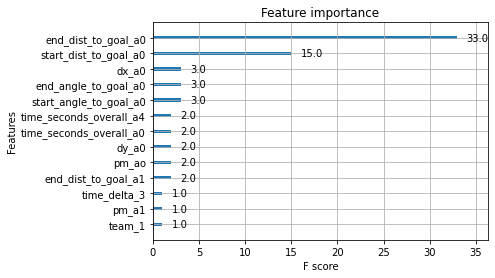

In [61]:
plot_importance(models['shots'])
    

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

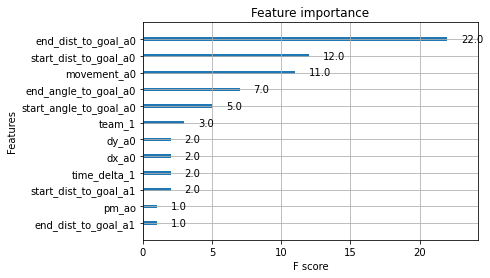

In [62]:
plot_importance(models['concedes'])

Text(0.5, 1.0, 'Shots Feature Importance')

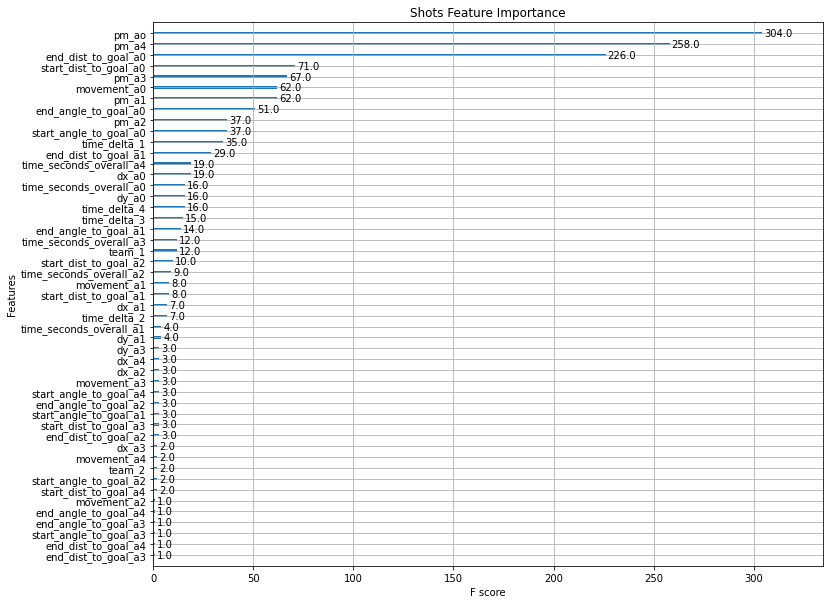

In [65]:
plt.rcParams["figure.figsize"] = (12, 10)
plot_importance(best_model_shots)
plt.title("Shots Feature Importance")

Text(0.5, 1.0, 'Conceeded Shots Feature Importance')

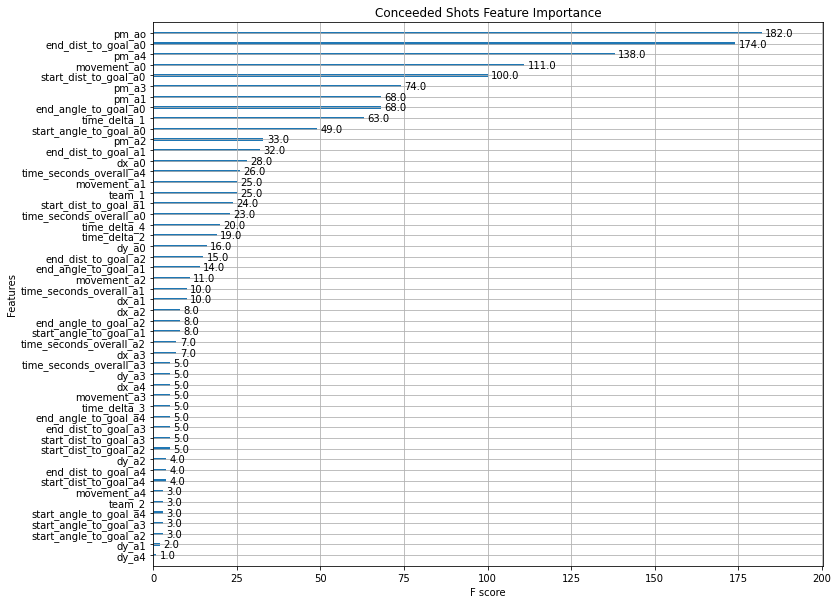

In [70]:
plt.rcParams["figure.figsize"] = (12, 10)
plot_importance(best_model_shots_conc)
plt.title("Conceeded Shots Feature Importance")

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


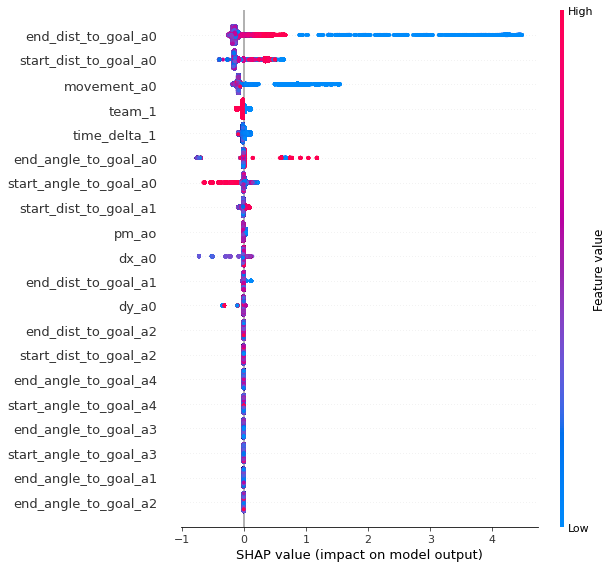

In [192]:
#SHapley Additive exPlanations
#Of the top 20 features, those at the top had greater contribution than those at the bottom. 
# Each dot represents each event. 
#The color represents the value of the feature (blue and red indicate low and high, respectively). 
#The horizontal axis shows the impact on the prediction
#strongly positive and negative impacts are plotted to the right and left, respectively. 
#For example, when the value of type movement ao is 1, the prediction is likely to be >1
import shap
explainer = shap.TreeExplainer(models[label])

shap_values = explainer.shap_values(df_X_test[features])
shap.summary_plot(shap_values, df_X_test[features])

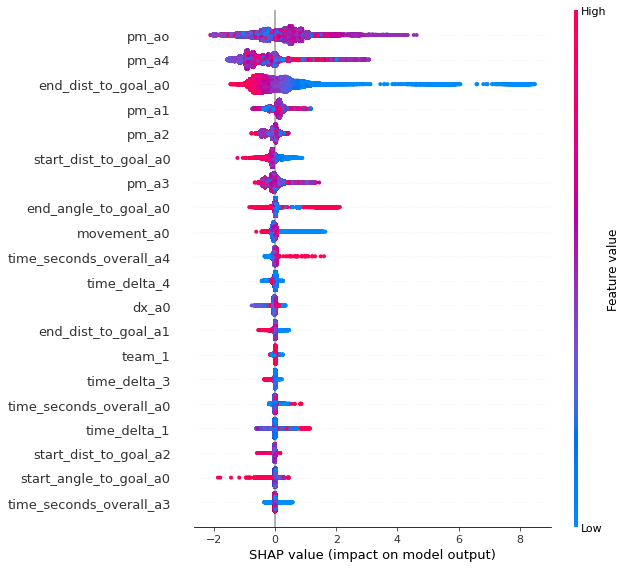

In [195]:
explainer = shap.TreeExplainer(best_model_shots)

shap_values = explainer.shap_values(df_X_test[features])
shap.summary_plot(shap_values, df_X_test[features])

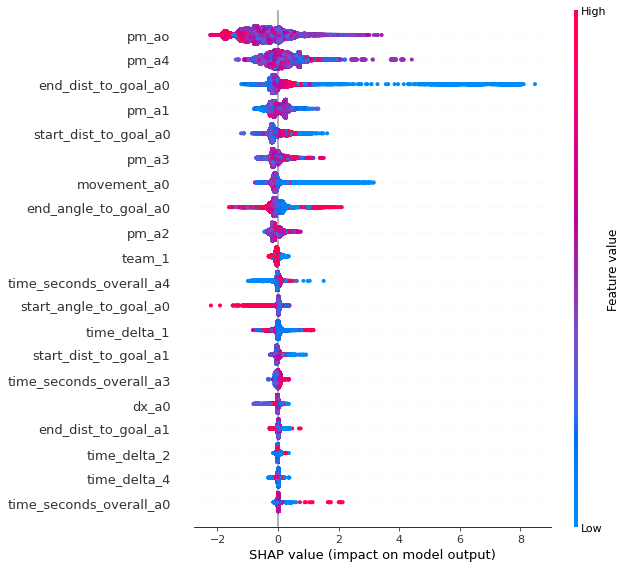

In [199]:
explainer = shap.TreeExplainer(best_model_shots_conc)

shap_values = explainer.shap_values(df_X_test[features])
shap.summary_plot(shap_values, df_X_test[features])

In [71]:
#Lets rank some players by our calculated scores
df_ranking = (df_values[['player_id', 'team_name', 'short_name', 'vaep_value']]
    .groupby(['player_id', 'team_name', 'short_name'])
    .agg(vaep_count=('vaep_value', 'count'),vaep_mean=('vaep_value', 'mean'),vaep_sum=('vaep_value', 'sum'))
    .sort_values('vaep_sum', ascending=False)
    .reset_index()
)

In [72]:
df_ranking['vaep_sum_mod'] = df_ranking['vaep_sum']

In [73]:
df_ranking = df_ranking.drop('vaep_sum', 1)

In [74]:
df_ranking

,player_id,team_name,short_name,vaep_count,vaep_mean,vaep_sum_mod
0,3286.0,Valencia Club de Fútbol,Dani Parejo,2961,0.032470,96.144661
1,221411.0,FC Augsburg,P. Max,2048,0.041428,84.844955
2,214062.0,Girona FC,Álex Granell,2314,0.030705,71.051544
3,14723.0,Real Madrid Club de Fútbol,T. Kroos,2496,0.026431,65.971870
4,228981.0,Stade Rennais FC,B. Bourigeaud,2235,0.028358,63.380920
...,...,...,...,...,...,...
3073,14817.0,FC Bayern München,R. Lewandowski,955,-0.099473,-94.996529
3074,7972.0,FC Barcelona,L. Suárez,1549,-0.067968,-105.283157
3075,8327.0,AS Roma,E. Džeko,1180,-0.096391,-113.740997
3076,3322.0,Real Madrid Club de Fútbol,Cristiano Ronaldo,1182,-0.101748,-120.266685


In [75]:
df_ranking.head(10)

,player_id,team_name,short_name,vaep_count,vaep_mean,vaep_sum_mod
0,3286.0,Valencia Club de Fútbol,Dani Parejo,2961,0.032470,96.144661
1,221411.0,FC Augsburg,P. Max,2048,0.041428,84.844955
2,214062.0,Girona FC,Álex Granell,2314,0.030705,71.051544
3,14723.0,Real Madrid Club de Fútbol,T. Kroos,2496,0.026431,65.971870
4,228981.0,Stade Rennais FC,B. Bourigeaud,2235,0.028358,63.380920
5,40301.0,FC Nantes,Lucas Lima,2000,0.031531,63.062069
6,3280.0,Sevilla FC,É. Banega,2783,0.022105,61.517353
7,3974.0,Getafe Club de Fútbol,D. Suárez,2121,0.028025,59.440311
8,26120.0,Angers SCO,T. Mangani,2553,0.022667,57.869301
9,25714.0,Olympique de Marseille,D. Payet,1975,0.028013,55.325218


In [76]:
df_player_games = pd.read_hdf('spadl.h5', 'player_games')
df_player_games = df_player_games[df_player_games['game_id'].isin(df_games['game_id'])]
df_minutes_played = (df_player_games[['player_id', 'minutes_played']]
    .groupby('player_id')
    .sum()
    .reset_index()
)

In [77]:
df_ranking.merge(df_minutes_played)

,player_id,team_name,short_name,vaep_count,vaep_mean,vaep_sum_mod,minutes_played
0,3286.0,Valencia Club de Fútbol,Dani Parejo,2961,0.032470,96.144661,3121.581247
1,221411.0,FC Augsburg,P. Max,2048,0.041428,84.844955,3057.387409
2,214062.0,Girona FC,Álex Granell,2314,0.030705,71.051544,2939.325674
3,14723.0,Real Madrid Club de Fútbol,T. Kroos,2496,0.026431,65.971870,3173.988615
4,14723.0,Germany,T. Kroos,1147,0.018750,21.506802,3173.988615
...,...,...,...,...,...,...,...
3071,20479.0,UC Sampdoria,F. Quagliarella,1000,-0.075290,-75.290398,2818.851418
3072,15004.0,Stade Malherbe Caen,I. Santini,1032,-0.073618,-75.973946,2873.488663
3073,25410.0,O.G.C. Nice Côte d'Azur,A. Pléa,1500,-0.053669,-80.503036,3152.602729
3074,269152.0,ACF Fiorentina,G. Simeone,998,-0.081334,-81.170853,3115.107580


In [78]:
df_ranking_p90 = df_ranking.merge(df_minutes_played)
df_ranking_p90['vaep_rating'] = df_ranking_p90['vaep_sum_mod'] * 90 / df_ranking_p90['minutes_played']
df_ranking_p90['vaep_rating_mod'] = df_ranking_p90['vaep_sum_mod'] * 90 / df_ranking_p90['minutes_played']
df_ranking_p90['actions_p90'] = df_ranking_p90['vaep_count'] * 90 / df_ranking_p90['minutes_played']

In [79]:
#450 is 5 games
MIN_THRESHOLD = 450
df_ranking_p90 = df_ranking_p90[df_ranking_p90['minutes_played']>MIN_THRESHOLD]
df_ranking_p90 = df_ranking_p90.sort_values('vaep_rating_mod', ascending=False)

In [80]:
df_ranking_p90 = df_ranking_p90.drop('vaep_rating', 1)

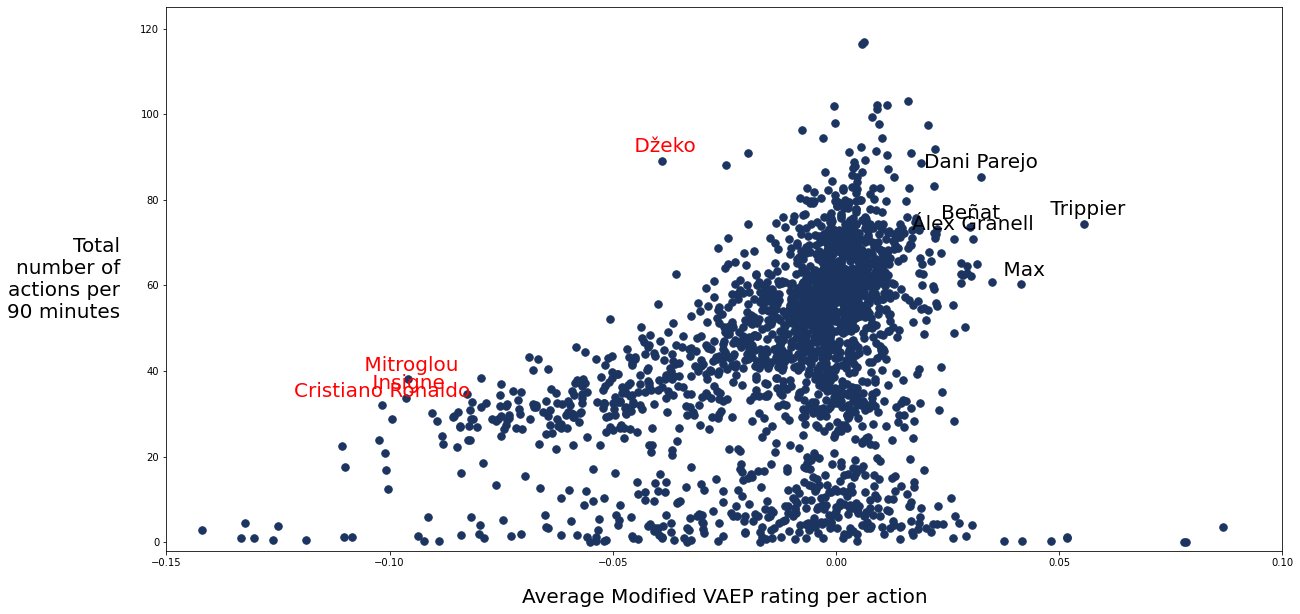

In [113]:
#Quantity/Quality tradeoff
plt.figure(figsize=(20, 10))
x = list(df_ranking_p90['vaep_mean'])
y = list(df_ranking_p90['actions_p90'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

# Plot 5 best players
x_best = list(df_ranking_p90['vaep_mean'][0:5])
y_best = list(df_ranking_p90['actions_p90'][0:5])
names = list(df_ranking_p90['short_name'][0:5])
names = [name.split(".")[-1] for name in names]

#Plot 5 worst players
x_worst = list(df_ranking_p90['vaep_mean'][2033:2038])
y_worst = list(df_ranking_p90['actions_p90'][2033:2038])
names1 = list(df_ranking_p90['short_name'][2033:2038])
names1 = [name.split(".")[-1] for name in names1]

plt.plot(x_best, y_best, '.', c='#D62A2E', markersize=0.2)
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i] + 2), fontsize=20, horizontalalignment='center')
    
plt.plot(x_worst, y_worst, '.', c='#D62A2E', markersize=0.2)
for i, txt in enumerate(names1):
    plt.annotate(txt, (x[2037-i], y[2037-i] + 2), fontsize=20, color = "r", horizontalalignment='center')

#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)
plt.xlim(-0.15, 0.10)
plt.ylim(-2, 125)
plt.xlabel('Average Modified VAEP rating per action', labelpad=20, fontsize=20)
plt.ylabel('Total\nnumber of\nactions per\n90 minutes', rotation=0, labelpad=20,
            verticalalignment='center', horizontalalignment='right', fontsize=20)

plt.show()

In [177]:
#Risk/Reward Tradeoff
df_risk = pd.pivot_table(df_values, values='vaep_value', index=['player_id', 'short_name', 'team_name'],
                                              columns=['result_name'], aggfunc=np.sum,
                                              fill_value=0)[['success', 'fail']]
df_risk = df_risk.reset_index()
df_risk = df_risk[0:-1]
df_risk = pd.merge(df_risk, df_minutes_played, on=['player_id'])
for result in ['success', 'fail']:
    df_risk[result] = df_risk[result] / df_risk['minutes_played'] * 90

In [178]:
df_risk = df_risk[df_risk['minutes_played']>MIN_THRESHOLD]
df_risk['vaep_rating'] = df_risk['success'] + df_risk['fail']
df_risk.sort_values('fail')

,player_id,short_name,team_name,success,fail,minutes_played,vaep_rating
1046,21385.0,L. Insigne,SSC Napoli,0.263120,-3.714004,3205.650420,-3.450884
3052,491409.0,M. Barrow,Atalanta Bergamasca Calcio,-0.311756,-3.340509,472.201289,-3.652265
478,8327.0,E. Džeko,AS Roma,-0.119807,-3.125869,3151.694572,-3.245676
92,3322.0,Cristiano Ronaldo,Real Madrid Club de Fútbol,-0.360458,-2.892999,3325.897321,-3.253457
2814,352993.0,Y. Karamoh,FC Internazionale Milano,0.492670,-2.734356,521.677886,-2.241686
...,...,...,...,...,...,...,...
493,8529.0,S. Larsson,Sweden,1.021724,0.229576,586.146410,1.251301
734,15256.0,P. Schwegler,Hannover 96,1.650411,0.244839,2397.856517,1.895250
2287,221411.0,P. Max,FC Augsburg,2.220906,0.270160,3057.387409,2.491066
512,8945.0,K. Trippier,England,3.788051,0.350828,541.159246,4.138879


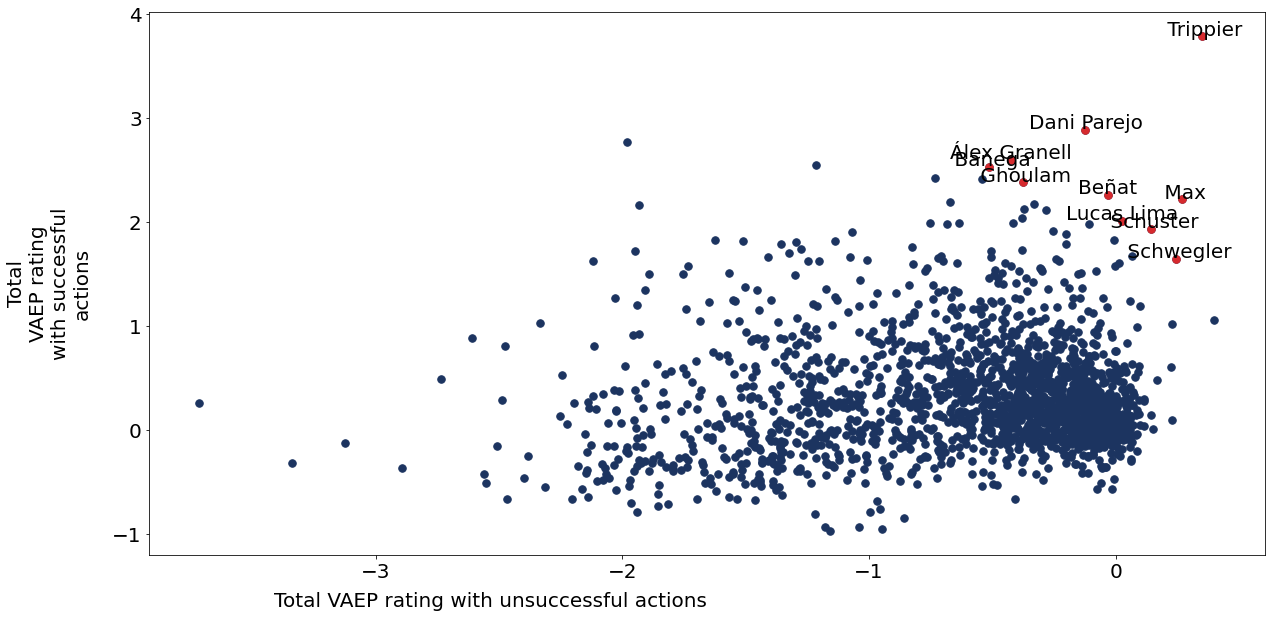

In [184]:
df_risk = df_risk.sort_values('vaep_rating', ascending=False)

plt.figure(figsize=(20, 10))
x = list(df_risk['fail'])
y = list(df_risk['success'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

# Plot 5 best players
x_best = list(df_risk['fail'][0:10])
y_best = list(df_risk['success'][0:10])
names = list(df_risk['short_name'][0:10])
names = [name.split(".")[-1] for name in names]
plt.plot(x_best, y_best, '.', c='#D62A2E', markersize=15)
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i] + 0.01), fontsize=20, horizontalalignment='center')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.xlim(-0.25, 0.01)
#plt.ylim(0, 1.2)
plt.xlabel('Total VAEP rating with unsuccessful actions', rotation=0, labelpad=20,
            verticalalignment='center', horizontalalignment='right', fontsize=20)
plt.ylabel('Total\nVAEP rating\nwith successful\nactions', labelpad=20, fontsize=20)

plt.show()

In [114]:
df_ranking

,player_id,team_name,short_name,vaep_count,vaep_mean,vaep_sum_mod
0,3286.0,Valencia Club de Fútbol,Dani Parejo,2961,0.032470,96.144661
1,221411.0,FC Augsburg,P. Max,2048,0.041428,84.844955
2,214062.0,Girona FC,Álex Granell,2314,0.030705,71.051544
3,14723.0,Real Madrid Club de Fútbol,T. Kroos,2496,0.026431,65.971870
4,228981.0,Stade Rennais FC,B. Bourigeaud,2235,0.028358,63.380920
...,...,...,...,...,...,...
3073,14817.0,FC Bayern München,R. Lewandowski,955,-0.099473,-94.996529
3074,7972.0,FC Barcelona,L. Suárez,1549,-0.067968,-105.283157
3075,8327.0,AS Roma,E. Džeko,1180,-0.096391,-113.740997
3076,3322.0,Real Madrid Club de Fútbol,Cristiano Ronaldo,1182,-0.101748,-120.266685
